Building ARIMA model on Air Passengers Data. 

Tasks to be performed:

    1. Find out if air passengers data is stationary ,if not convert to stationary
    
    2. Build ARIMA model to predict values for next 10 years.


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

#Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf         #for determining (p,q) orders
from pmdarima import auto_arima        #for determining arima orders

import warnings
warnings.filterwarnings("ignore")


In [2]:
airline=pd.read_csv('~\Downloads\DataSets\AirPassengers.csv',index_col=0,parse_dates=True)
airline.index.freq= 'MS'

In [3]:
airline.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
airline.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


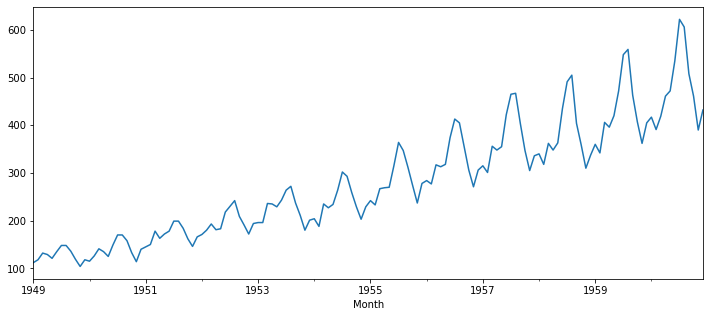

In [5]:
airline['#Passengers'].plot(figsize=(12,5)).autoscale(axis='x', tight=True)

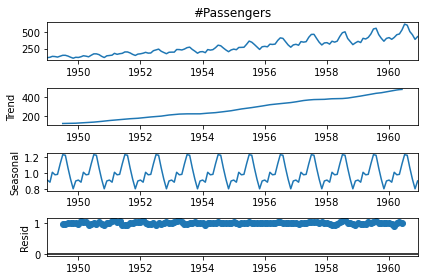

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

results=seasonal_decompose(airline['#Passengers'],model='mul')
results.plot();  #;is important to show only 1 graph otherwise it shows 2

#1st is observations:actual data
#2nd is Trend :rising exponentially
#3rd is Seasonal :shows seasonality of each year
#4h is Residual: shows noise in data


#this data looks non stationary so lets make it stationary using differencing 

In [7]:
stepwise_fit = auto_arima(airline['#Passengers'],start_p=1,start_q=1,
                         max_p=3,max_q=3,m=12,
                         start_P=0,seasonal=True,
                         d=None,D=1,trace=True,
                         error_action='ignore',             #we dont want to know if a order does not work
                         supress_warnings=True,             #we dont want convergence settings
                          stepwise=True)                    #set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.38 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.24 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.54 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=1.01 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.15 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [8]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Thu, 26 Jan 2023   AIC                           1019.178
Time:                                     12:47:06   BIC                           1030.679
Sample:                                 01-01-1949   HQIC                          1023.851
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# from above summary we get to know that we need 1st order differencing (p,i,q)=(0,1,1) i=1 means differnecing lag =1

In [10]:
from statsmodels.tsa.statespace.tools import diff
airline['d1']= diff(airline['#Passengers'],k_diff=1)

In [11]:
from statsmodels.tsa.stattools import adfuller    #augmented dickey fuller test
print("Augmented Dickey Fuller Test on Airline Passengers Data")

dftest=adfuller(airline['d1'].dropna(),autolag='AIC')           

#AIC= Akieky Information Criterion Lower the aic better the prediction

dftest

Augmented Dickey Fuller Test on Airline Passengers Data


(-2.8292668241699994,
 0.0542132902838255,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

In [12]:
print("Augmented Dickey Fuller Test on Airline Passengers Data\n")
dfout=pd.Series(dftest[0:4],index=['ADF test Statistics','p-value(should be less than 0.05 to make data stationary)','no. of lags used','no. of observations'])

for key,val in dftest[4].items():
    dfout[f'critical value({key})']=val

print(dfout)

#if p value is less than 0.05 it means we can reject the null hypothesis it after 1st order differencing we made our data stationary.

Augmented Dickey Fuller Test on Airline Passengers Data

ADF test Statistics                                           -2.829267
p-value(should be less than 0.05 to make data stationary)      0.054213
no. of lags used                                              12.000000
no. of observations                                          130.000000
critical value(1%)                                            -3.481682
critical value(5%)                                            -2.884042
critical value(10%)                                           -2.578770
dtype: float64


In [13]:
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [14]:
acf(airline['#Passengers'])   #here lags are 22

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376])

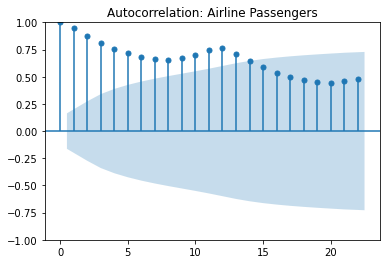

In [15]:
title="Autocorrelation: Airline Passengers"
lags=22
plot_acf(airline['#Passengers'],title=title,lags=lags);

#blue shaded area is confidence, 0-22 are lags

In [16]:
#same for pacf
pacf(airline['#Passengers']) 

array([ 1.        ,  0.95467704, -0.26527732,  0.05546955,  0.10885622,
        0.08112579,  0.00412541,  0.15616955,  0.10370833,  0.28878144,
        0.20691805,  0.2411297 , -0.15800498, -0.7183246 , -0.08948064,
        0.22160591,  0.13462253,  0.11561572,  0.1948294 ,  0.09665618,
       -0.20215868, -0.0936381 ])

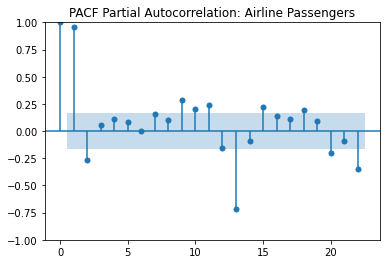

In [17]:
title="PACF Partial Autocorrelation: Airline Passengers"
lags=22
plot_pacf(airline['#Passengers'],title=title,lags=lags);

#blue shaded area is confidence, 0-22 are lags

In [18]:
#go to https://people.duke.edu/~rnau/arimrule.htm to know more about arima rules

In [19]:
airline.shape

(144, 2)

In [20]:
#set 1 year for testing
train=airline.iloc[:132]
test=airline.iloc[132:]

In [25]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults


In [26]:
model=ARIMA(train["#Passengers"],order=(1,1,0))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -631.365
Date:                Thu, 26 Jan 2023   AIC                           1266.731
Time:                        12:48:11   BIC                           1272.481
Sample:                    01-01-1949   HQIC                          1269.068
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2912      0.090      3.236      0.001       0.115       0.468
sigma2       898.3992     91.552      9.813      0.000     718.961    1077.838
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 6.92
Prob(Q):                              0.47   Prob(JB):                         0.03
Heteroskedasticity (H):               7.36   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
#obtain predicted value
start=len(train)
end=len(train)+len(test)-1
predictions=results.predict(start=start,end=end,dynamic=False, typ='levels').rename("ARIMA(1,1,0) Predictions")

#typstr {‘linear’, ‘levels’}
#‘linear’ : Linear prediction in terms of the differenced endogenous variables.
#‘levels’ : Predict the levels of the original endogenous variables.
#endogenous variables: variables whose values are changed based on relationship with other variables in the model.

In [29]:
#compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test['#Passengers'][i]}")

predicted=417.52242111843253, expected=417
predicted=421.1691892734876, expected=391
predicted=422.2311977981129, expected=419
predicted=422.54047496036225, expected=461
predicted=422.63054237589716, expected=472
predicted=422.65677172720825, expected=535
predicted=422.6644102151799, expected=622
predicted=422.6666346887401, expected=606
predicted=422.66728249791885, expected=508
predicted=422.66747115232215, expected=461
predicted=422.6675260920869, expected=390
predicted=422.6675420915955, expected=432


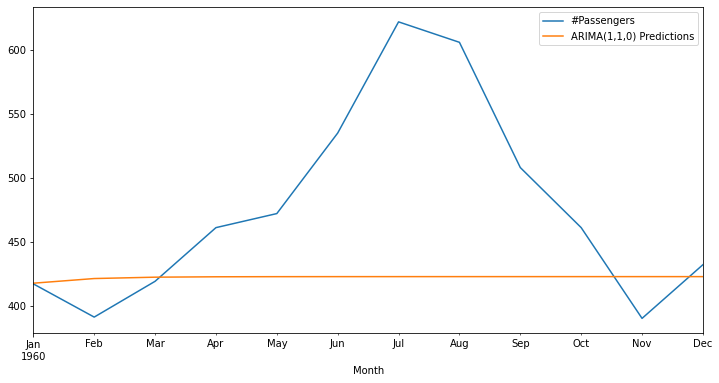

In [31]:
#Plot predictions
ax= test['#Passengers'].plot(legend=True,figsize=(12,6))

predictions.plot(legend=True)

ax.autoscale(axis='x',tight=True)

#### for mid march and mid oct error is zero as both lines are crossing, in july error is huge and in feb and nov errors are small

In [36]:
#to get central value or avg error in each predictions we use  mean squared error and absolute error

In [39]:
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test['#Passengers'],predictions)
print(f'ARIMA(1,1,0) MSE Error: {error:11.10}')

ARIMA(1,1,0) MSE Error: 8392.457547


In [42]:
from statsmodels.tools.eval_measures import rmse
error=rmse(test['#Passengers'],predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error:  91.6103572


## Retrain the model on full data and forecast the future

In [44]:
model=ARIMA(airline['#Passengers'],order=(1,1,0))
results=model.fit()

In [56]:
fcast=results.predict(len(airline),len(airline)+12*10,typ='levels').rename("ARIMA(1,1,0) forecast")
#12= months,10=years

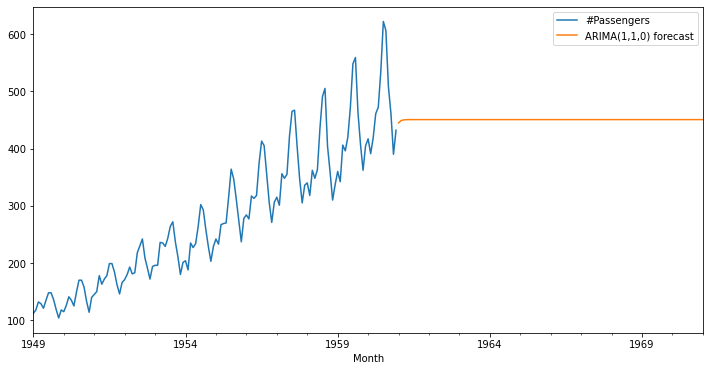

In [47]:
#Plot predictions against known values

ax=airline['#Passengers'].plot(legend=True, figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#ARIMA model is not able to perform accurately trend is ok but seatonality is missing as we used non seasonal arima model 

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
model=SARIMAX(train['#Passengers'],order=(1,1,0),seasonal_order=(2,1,1,12),enforse_invertibility=False)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          #Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -442.549
Date:                              Thu, 26 Jan 2023   AIC                            895.098
Time:                                      13:46:23   BIC                            908.994
Sample:                                  01-01-1949   HQIC                           900.741
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3096      0.084     -3.708      0.000      -0.473      -0.146
ar.S.L12       0.7147      0.231      3.096      0.002       0.262       1.167
ar.S.L24       0.2841      0.099      2.858      0.004       0.089       0.479
ma.S.L12      -0.9762      1.868     -0.523      0.601      -4.638       2.685
sigma2        87.8043    144.491      0.608      0.543    -195.393     371.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.95   Prob(JB):                         0.91
Heteroskedasticity (H):               1.59   Skew:                            -0.06
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
#obtain predicted value
start=len(train)
end=len(train)+len(test)-1
predictions=results.predict(start=start,end=end,dynamic=False, typ='levels').rename("SARIMAX(1,1,0) Predictions")


In [52]:
#compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test['#Passengers'][i]}")

predicted=420.4198114317021, expected=417
predicted=399.9737756215222, expected=391
predicted=462.4362186098098, expected=419
predicted=450.69570224401554, expected=461
predicted=475.16523321842374, expected=472
predicted=536.8794952476154, expected=535
predicted=612.9161532645936, expected=622
predicted=625.9635313174136, expected=606
predicted=519.9660698771064, expected=508
predicted=463.6085752815911, expected=461
predicted=414.4509312782821, expected=390
predicted=455.23251194763776, expected=432


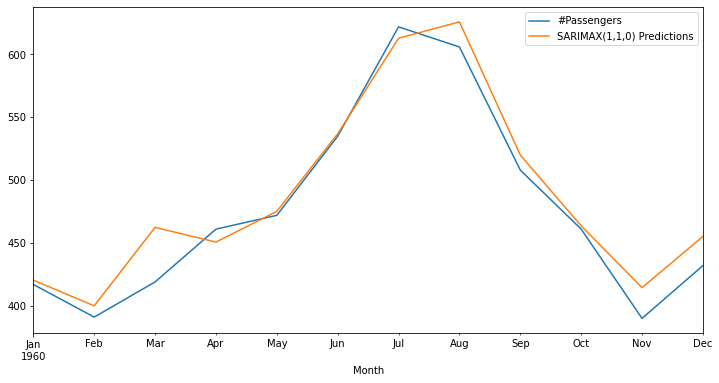

In [53]:
#Plot predictions
ax= test['#Passengers'].plot(legend=True,figsize=(12,6))

predictions.plot(legend=True)

ax.autoscale(axis='x',tight=True)

In [54]:
#for SARIMAX
from sklearn.metrics import mean_squared_error
error=mean_squared_error(test['#Passengers'],predictions)
print(f'ARIMA(1,1,0) MSE Error: {error:11.10}')

#we can see that error is very less in SARIMAX so it is a better model for this data

ARIMA(1,1,0) MSE Error: 322.2755501


In [55]:
#for SARIMAX
from statsmodels.tools.eval_measures import rmse
error=rmse(test['#Passengers'],predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 17.95203471


## Retain on full data

In [60]:
model=SARIMAX(airline['#Passengers'],order=(1,1,0),seasonal_order=(2,1,1,12),enforse_invertibility=False)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -502.605
Date:                              Thu, 26 Jan 2023   AIC                           1015.210
Time:                                      14:02:15   BIC                           1029.586
Sample:                                  01-01-1949   HQIC                          1021.052
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3782      0.077     -4.900      0.000      -0.529      -0.227
ar.S.L12       0.6902      0.183      3.767      0.000       0.331       1.049
ar.S.L24       0.3082      0.105      2.927      0.003       0.102       0.515
ma.S.L12      -0.9756      1.299     -0.751      0.453      -3.522       1.571
sigma2       113.0145    121.319      0.932      0.352    -124.767     350.796
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                11.90
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               2.67   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
fcast=results.predict(len(airline),len(airline)+12*10,typ='levels').rename("SARIMAX(1,1,0) forecast")
#12= months,10=years

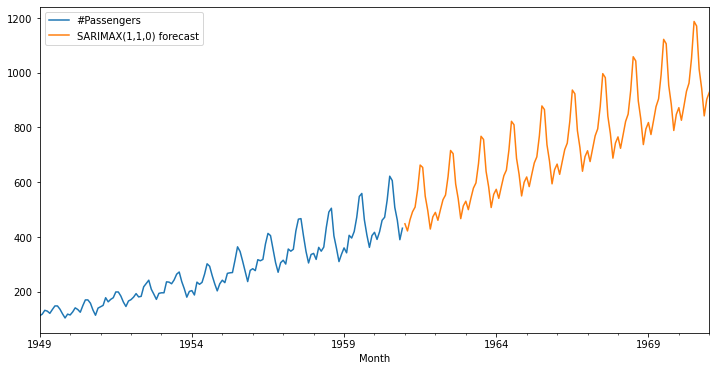

In [62]:
#Plot predictions against known values

ax=airline['#Passengers'].plot(legend=True, figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#now we can see that sarimax has preserved the value of seasonality

In [ ]:
#we use auto scale to remove missing values also.
#To check which model ia best just simply use auto arima but if you want to do thing manually
#then use arima and sarimax seperately with ADF,ACF, PACF